## パラメータチューニング
optunaを用いたパラメータ調整を、各変数の内容を勉強しつつ丁寧に行う。

[詳細はこちら](https://qiita.com/c60evaporator/items/351188110f328ff921b9#%E3%83%99%E3%82%A4%E3%82%BA%E6%9C%80%E9%81%A9%E5%8C%96bayesianoptimization%E3%81%AE%E5%A0%B4%E5%90%88)

In [2]:
# ひとつ上のディレクトリをパスに追加
import os
import sys
sys.path.append(os.path.join(os.path.dirname("/Users/naoki/git/Horse-Racing/Notebook/plot.ipynb"), '..'))

In [3]:
from backend.module.preparing import TableMerger
from backend.module.simulation import RankPredictor
from backend.module.repository import (
    Peds,
    Result,
    Race,
    HorseProfile,
    RaceCard,
    OriginalRaceCard,
    Refund,
)
from backend.module.handler import (
    PredictionBrancher,
    PredictionExtractor,
    RefundCalculator,
)
from backend.module.record import PredictionWriter

from backend.environment.mapping import Mapping
from backend.environment.columns import Columns

In [5]:
import csv
import time
import warnings
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
import datetime
import pickle
import lightgbm as lgb
import optuna
import optuna.integration.lightgbm as lgb_o
from datetime import datetime
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, validation_curve, cross_validate
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, r2_score, mean_squared_error, ndcg_score
from tqdm import tqdm
from bs4 import BeautifulSoup
from itertools import combinations
from itertools import permutations
from urllib.request import urlopen
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK

warnings.simplefilter('ignore')

In [6]:
table_merger = TableMerger()
race_card = RaceCard()
df = table_merger(race_card.preprocessed_df)

merge last all datas by jockey_id: 100%|██████████| 718/718 [00:58<00:00, 12.20it/s] 


In [4]:
# 必要なデータの準備
# race_results(=r.data_c)の作成
hr = c.HorseResults(_dat.horse_results["overall"])
p = c.Peds(_dat.ped_results["overall"])
r = c.Results(_dat.race_results["overall"], hr, p, avg=False)

# r.data_cをtrain, test, validの3種のデータに分割
train, test = m.split_data(r.data_c)
train, valid = m.split_data(train)

# クエリデータの生成
query_train = list()
query_valid = list()
query_test = list()
for i in train.groupby(level=0):
    query_train.append(len(i[1]))
for i in valid.groupby(level=0):
    query_valid.append(len(i[1]))
for i in test.groupby(level=0):
    query_test.append(len(i[1]))

drop_list = ['rank_binary', 'rank_regression', 'rank_lambdarank', 'date', 'jockey_id', 'breeder_id', 'owner_id', 'trainer_id', 'birthday', 'horse_id']
OBJECTIVE_VARIALBLE = 'rank_lambdarank'
USE_EXPLANATORY = [col for col in r.data_c.columns if col not in drop_list]

# train, valid, testを説明変数と目的変数に分割
X_train = train.drop(drop_list+['odds'], axis=1)
y_train = {'rank_binary': train['rank_binary'], 'rank_regression': train['rank_regression'], 'rank_lambdarank': train['rank_lambdarank']}
X_valid = valid.drop(drop_list+['odds'], axis=1)
y_valid = {'rank_binary': valid['rank_binary'], 'rank_regression': valid['rank_regression'], 'rank_lambdarank': valid['rank_lambdarank']}
X_test = test.drop(drop_list, axis=1)
y_test = {'rank_binary': test['rank_binary'], 'rank_regression': test['rank_regression'], 'rank_lambdarank': test['rank_lambdarank']}

# lgbm用のデータに変形する
lgb_train = {
                'binary': lgb_o.Dataset(X_train.values, y_train['rank_binary'].values, group=query_train), 
                'regression': lgb_o.Dataset(X_train.values, y_train['rank_regression'].values, group=query_train),
                'lambdarank': lgb_o.Dataset(X_train.values, y_train['rank_lambdarank'].values, group=query_train)
            }

lgb_valid = {
                'binary': lgb_o.Dataset(X_valid.values, y_valid['rank_binary'].values, reference=lgb_train['binary'], group=query_valid), 
                'regression': lgb_o.Dataset(X_valid.values, y_valid['rank_regression'].values, reference=lgb_train['regression'], group=query_valid),
                'lambdarank': lgb_o.Dataset(X_valid.values, y_valid['rank_lambdarank'].values, reference=lgb_train['lambdarank'], group=query_valid)
            }

# 乱数シード
seed = 42
# 評価指標をRMSEに指定
# 詳細はこちら: https://qiita.com/c60evaporator/items/ca7eb70e1508d2ba5359#%E3%81%A9%E3%82%8C%E3%81%8C%E3%81%84%E3%81%84%E3%81%AE-1
scoring = 'neg_root_mean_squared_error' 
# モデル作成
# n_estimators: 木の数
# boosting_type: アンサンブル学習を行う際、利用する型の選択(ex. gbdt, dart, rf, gossなど)
lgb_clf_binary = lgb.LGBMClassifier(boosting_type='dart', objective='binary', random_state=seed, n_estimators=50)
lgb_clf_regression = lgb.LGBMRegressor(boosting_type='dart', objective='regression', random_state=seed, n_estimators=50)
lgb_clf_lambdarank = lgb.LGBMRanker(boosting_type='dart', objective='lambdarank', random_state=seed, n_estimators=50)

ori_params_binary = {
    'objective': 'binary',
    'metric': "binary_logloss",
    'feature_pre_filter': False,
    'boosting_type': 'dart'
}

ori_params_regression = {
    'objective': 'regression',
    'metric': 'rmse',
    'feature_pre_filter': False,
    'boosting_type': 'dart'
}

ori_params_lambdarank = {
    'objective': 'lambdarank',
    'metric': "ndcg",
    'feature_pre_filter': False,
    'boosting_type': 'dart',
    'eval_at': [1000]
}

merge p5  data: 100%|██████████| 496/496 [00:37<00:00, 13.33it/s] 


In [8]:
ori_params_lambdarank = {
    'objective': 'lambdarank',
    'metric': "ndcg",
    'feature_pre_filter': False,
    'boosting_type': 'gbdt',
    'eval_at': [1000]
}
# パラメータ設定2(lambdarank)
lgb_lambdarank_results={}
lgb_clf_o_lambdarank = lgb_o.train(
                        params=ori_params_lambdarank,
                        train_set=lgb_train['lambdarank'],
                        valid_sets=(lgb_train['lambdarank'], lgb_valid['lambdarank']),
                        valid_names=['train', 'valid'],
                        verbose_eval=False,
                        early_stopping_rounds=10,
                        evals_result=lgb_lambdarank_results
                        )

[I 2022-04-25 13:47:48,845] A new study created in memory with name: no-name-fd576a76-57a6-452e-887e-43e565a1a1fd
feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


feature_fraction, val_score: 0.602550:  14%|#4        | 1/7 [00:02<00:12,  2.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


feature_fraction, val_score: 0.603333:  29%|##8       | 2/7 [00:04<00:10,  2.05s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


feature_fraction, val_score: 0.606500:  43%|####2     | 3/7 [00:06<00:08,  2.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


feature_fraction, val_score: 0.611934:  57%|#####7    | 4/7 [00:09<00:07,  2.46s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


feature_fraction, val_score: 0.611934:  71%|#######1  | 5/7 [00:13<00:05,  2.96s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


feature_fraction, val_score: 0.611934:  86%|########5 | 6/7 [00:16<00:02,  2.97s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:   5%|5         | 1/20 [00:04<01:27,  4.61s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  10%|#         | 2/20 [00:08<01:13,  4.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  15%|#5        | 3/20 [00:10<00:54,  3.23s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  20%|##        | 4/20 [00:13<00:47,  2.96s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  25%|##5       | 5/20 [00:15<00:42,  2.81s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  30%|###       | 6/20 [00:20<00:46,  3.34s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  35%|###5      | 7/20 [00:23<00:44,  3.46s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  40%|####      | 8/20 [00:28<00:47,  3.94s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  45%|####5     | 9/20 [00:32<00:42,  3.84s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  50%|#####     | 10/20 [00:35<00:35,  3.59s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  55%|#####5    | 11/20 [00:36<00:26,  2.94s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  60%|######    | 12/20 [00:38<00:20,  2.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  65%|######5   | 13/20 [00:39<00:15,  2.23s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  70%|#######   | 14/20 [00:43<00:15,  2.53s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  75%|#######5  | 15/20 [00:45<00:12,  2.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  80%|########  | 16/20 [00:48<00:10,  2.51s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  85%|########5 | 17/20 [00:50<00:07,  2.41s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  90%|######### | 18/20 [00:53<00:05,  2.68s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


num_leaves, val_score: 0.611934:  95%|#########5| 19/20 [00:54<00:02,  2.25s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


bagging, val_score: 0.611934:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


bagging, val_score: 0.611934:  10%|#         | 1/10 [00:02<00:23,  2.60s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


bagging, val_score: 0.611934:  20%|##        | 2/10 [00:04<00:18,  2.33s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


bagging, val_score: 0.611934:  30%|###       | 3/10 [00:07<00:18,  2.58s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


bagging, val_score: 0.611934:  40%|####      | 4/10 [00:12<00:20,  3.36s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


bagging, val_score: 0.611934:  50%|#####     | 5/10 [00:15<00:16,  3.29s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


bagging, val_score: 0.611934:  60%|######    | 6/10 [00:17<00:12,  3.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


bagging, val_score: 0.611934:  70%|#######   | 7/10 [00:20<00:08,  2.87s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


bagging, val_score: 0.611934:  80%|########  | 8/10 [00:23<00:05,  2.83s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


bagging, val_score: 0.611934:  90%|######### | 9/10 [00:25<00:02,  2.55s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


feature_fraction_stage2, val_score: 0.611934:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


feature_fraction_stage2, val_score: 0.611934:  17%|#6        | 1/6 [00:02<00:14,  2.87s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


feature_fraction_stage2, val_score: 0.611934:  33%|###3      | 2/6 [00:05<00:10,  2.63s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


feature_fraction_stage2, val_score: 0.611934:  50%|#####     | 3/6 [00:08<00:08,  2.79s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


feature_fraction_stage2, val_score: 0.611934:  67%|######6   | 4/6 [00:10<00:05,  2.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


feature_fraction_stage2, val_score: 0.611934:  83%|########3 | 5/6 [00:13<00:02,  2.64s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:   5%|5         | 1/20 [00:02<00:53,  2.82s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  10%|#         | 2/20 [00:05<00:46,  2.57s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  15%|#5        | 3/20 [00:07<00:44,  2.63s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  20%|##        | 4/20 [00:10<00:42,  2.64s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  25%|##5       | 5/20 [00:12<00:33,  2.22s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  30%|###       | 6/20 [00:14<00:31,  2.24s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  35%|###5      | 7/20 [00:17<00:34,  2.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  40%|####      | 8/20 [00:20<00:33,  2.77s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  45%|####5     | 9/20 [00:24<00:34,  3.12s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  50%|#####     | 10/20 [00:29<00:34,  3.48s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  55%|#####5    | 11/20 [00:30<00:27,  3.02s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  60%|######    | 12/20 [00:33<00:23,  2.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  65%|######5   | 13/20 [00:36<00:20,  2.95s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  70%|#######   | 14/20 [00:39<00:18,  3.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  75%|#######5  | 15/20 [00:43<00:15,  3.13s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  80%|########  | 16/20 [00:47<00:13,  3.39s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  85%|########5 | 17/20 [00:50<00:10,  3.48s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  90%|######### | 18/20 [00:55<00:07,  3.90s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


regularization_factors, val_score: 0.611934:  95%|#########5| 19/20 [00:58<00:03,  3.60s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


min_data_in_leaf, val_score: 0.611934:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


min_data_in_leaf, val_score: 0.611934:  20%|##        | 1/5 [00:02<00:09,  2.45s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


min_data_in_leaf, val_score: 0.611934:  40%|####      | 2/5 [00:04<00:07,  2.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


min_data_in_leaf, val_score: 0.611934:  60%|######    | 3/5 [00:08<00:06,  3.11s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


min_data_in_leaf, val_score: 0.611934:  80%|########  | 4/5 [00:11<00:02,  2.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 98515, number of used features: 103


min_data_in_leaf, val_score: 0.611934: 100%|##########| 5/5 [00:13<00:00,  2.79s/it]


In [11]:
# パラメータ設定2(binary)
lgb_binary_results={}
lgb_clf_o_binary = lgb_o.train(
                        params=ori_params_binary,
                        train_set=lgb_train['binary'],
                        valid_sets=(lgb_train['binary'], lgb_valid['binary']),
                        valid_names=['train', 'valid'],
                        verbose_eval=False,
                        early_stopping_rounds=10,
                        evals_result=lgb_binary_results
                        )

# パラメータ設定2(regression)
lgb_regression_results={}
lgb_clf_o_regression = lgb_o.train(
                        params=ori_params_regression,
                        train_set=lgb_train['regression'],
                        valid_sets=(lgb_train['regression'], lgb_valid['regression']),
                        valid_names=['train', 'valid'],
                        verbose_eval=False,
                        early_stopping_rounds=10,
                        evals_result=lgb_regression_results
                        )

# パラメータ設定2(lambdarank)
lgb_lambdarank_results={}
lgb_clf_o_lambdarank = lgb_o.train(
                        params=ori_params_lambdarank,
                        train_set=lgb_train['lambdarank'],
                        valid_sets=(lgb_train['lambdarank'], lgb_valid['lambdarank']),
                        valid_names=['train', 'valid'],
                        verbose_eval=False,
                        early_stopping_rounds=10,
                        evals_result=lgb_lambdarank_results
                        )

In [33]:
best_params_lambdarank = lgb_clf_o_lambdarank.params
lgb_clf_lambdarank.set_params(**best_params_lambdarank)

LGBMRanker(bagging_fraction=1.0, bagging_freq=0, early_stopping_round=10,
           eval_at=[1000], feature_fraction=0.5, feature_pre_filter=False,
           lambda_l1=2.5175606453305353, lambda_l2=1.3485498741964842e-07,
           metric='ndcg', min_child_samples=100, n_estimators=50,
           num_iterations=1000, num_leaves=7, objective='lambdarank',
           random_state=42)

In [22]:
cv = KFold(n_splits=3, shuffle=True, random_state=seed)  # KFoldでクロスバリデーション分割指定
fit_params_lambdarank = {
                        'callbacks': [
                                        lgb.early_stopping(
                                        stopping_rounds=10, # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
                                        verbose=0)
                                    ],  # 学習中のコマンドライン出力
                        'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
                        'eval_set': [(X_train.values, y_train['rank_lambdarank'].values)]  # early_stopping_roundsの評価指標算出用データ
                }

In [26]:
train_sizes, train_scores, valid_scores = learning_curve(   
                                                            estimator=lgb_clf_lambdarank,
                                                            X=X_train.values, y=y_train['rank_lambdarank'].values,
                                                            train_sizes=np.linspace(0.1, 1.0, 10),
                                                            fit_params=fit_params_lambdarank,
                                                            cv=cv, scoring=scoring, n_jobs=-1, verbose=-1
                                                        )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  30 | elapsed:    6.8s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.5s finished


In [188]:
def _learning_curve_lambdarank(extimator, X, y, group, train_sizes, rank_values={0: 10, 1: 5, 2: 3}, cv=0.3):
    # X_trainのデータの何割かを用いたデータ(_X_train)から、X_testを予測し、的中率をグラフ化する。
    # 学習データの利用率とスコアの関係性のプロットが目的
    group_train = group[:int(len(group)*(1-cv))]
    group_test = group[int(len(group)*(1-cv)):]
    X_train = X[:sum(group_train)]
    y_train = y[:sum(group_train)]
    X_test = X[sum(group_train):]
    y_test = y[sum(group_train):]
    for rate in train_sizes:
        _group_train = group_train[:int(len(group_train)*rate)]
        _X_train = X_train[:sum(_group_train)]
        _y_train = y_train[:sum(_group_train)]
        extimator.fit(
            _X_train.values,
            _y_train.values,
            group=_group_train,
        )
        predict = extimator.predict(X_test)
        print(np.repeat(np.arange(len(group_test)), group_test))
        print(len(predict), len(y_test), len(np.repeat(np.arange(len(group_test)), group_test)))
        df = pd.DataFrame({
                            'query_id': np.repeat(np.arange(len(group_test)), group_test),
                            'predict': predict,
                            'correct': y_test})
        for race in df.groupby(level=0):
            print(race)
            race = race[1].sort_values('predict', ascending=False)
            # for rank_idx, score in rank_values.items():
            #     if race.iloc[rank_idx] == score:
            #         valid_score

In [2]:
# for i in y_test['rank_lambdarank'].groupby(level=0):
#     print(i[1])

In [3]:
# try: best_params_lambdarank.pop('num_iterations')
# except: pass
# try: best_params_lambdarank.pop('early_stopping_round')
# except: pass
# lgb_clf_lambdarank = lgb.LGBMRanker(**best_params_lambdarank)
# _learning_curve_lambdarank(lgb_clf_lambdarank, X_train, y_train['rank_lambdarank'], query_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=0.3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  30 | elapsed:    6.0s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.5s finished


posx and posy should be finite values
posx and posy should be finite values


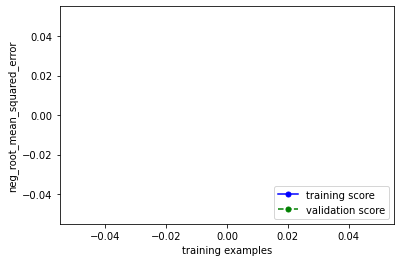

In [42]:
## 学習曲線
# 最適パラメータを学習器にセット
best_params_lambdarank = lgb_clf_o_lambdarank.params
lgb_clf_lambdarank.set_params(**best_params_lambdarank)
# 学習曲線の取得
train_sizes, train_scores, valid_scores = learning_curve(   
                                                            estimator=lgb_clf_lambdarank,
                                                            X=X_train.values, 
                                                            y=y_train['rank_lambdarank'].values,
                                                            train_sizes=np.linspace(0.1, 1.0, 10),
                                                            fit_params=fit_params_lambdarank,
                                                            cv=cv, 
                                                            scoring=scoring, 
                                                            n_jobs=-1, 
                                                            verbose=-1
                                                        )
# 学習データ指標の平均±標準偏差を計算
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
train_center = train_mean
train_high = train_mean + train_std
train_low = train_mean - train_std
# 検証データ指標の平均±標準偏差を計算
valid_mean = np.mean(valid_scores, axis=1)
valid_std  = np.std(valid_scores, axis=1)
valid_center = valid_mean
valid_high = valid_mean + valid_std
valid_low = valid_mean - valid_std
# training_scoresをプロット
plt.plot(train_sizes, train_center, color='blue', marker='o', markersize=5, label='training score')
plt.fill_between(train_sizes, train_high, train_low, alpha=0.15, color='blue')
# validation_scoresをプロット
plt.plot(train_sizes, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
plt.fill_between(train_sizes, valid_high, valid_low, alpha=0.15, color='green')
# 最高スコアの表示
best_score = valid_center[len(valid_center) - 1]
plt.text(np.amax(train_sizes), valid_low[len(valid_low) - 1], f'best_score={best_score}', color='black', verticalalignment='top', horizontalalignment='right')
# 軸ラベルおよび凡例の指定
plt.xlabel('training examples')  # 学習サンプル数を横軸ラベルに
plt.ylabel(scoring)  # スコア名を縦軸ラベルに
plt.legend(loc='lower right')  # 凡例

In [14]:
# ## 検証曲線
# # 検証曲線描画対象パラメータ
# valid_curve_params = {
#                         'reg_alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1],
#                         'reg_lambda': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1],
#                         'num_leaves': [2, 3, 4, 5, 6],
#                         'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#                         'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#                         'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
#                         'min_child_samples': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#                     }
# param_scales = {
#                 'reg_alpha': 'log',
#                 'reg_lambda': 'log',
#                 'num_leaves': 'linear',
#                 'colsample_bytree': 'linear',
#                 'subsample': 'linear',
#                 'subsample_freq': 'linear',
#                 'min_child_samples': 'linear'
#                 }
# # 最適パラメータを上記描画対象に追加
# for k, v in valid_curve_params.items():
#     if best_params[k] not in v:
#         v.append(best_params[k])
#         v.sort()
# for i, (k, v) in enumerate(valid_curve_params.items()):
#     # モデルに最適パラメータを適用
#     lgb_clf_regression.set_params(**best_params)
#     # 検証曲線を描画
#     train_scores, valid_scores = validation_curve(
#                                                     estimator=lgb_clf_regression,
#                                                     X=X_train, y=y_train['rank_lambdarank'],
#                                                     param_name=k,
#                                                     param_range=v,
#                                                     fit_params=fit_params,
#                                                     cv=cv, scoring=scoring,
#                                                     n_jobs=-1, verbose=-1)
#     # 学習データに対するスコアの平均±標準偏差を算出
#     train_mean = np.mean(train_scores, axis=1)
#     train_std  = np.std(train_scores, axis=1)
#     train_center = train_mean
#     train_high = train_mean + train_std
#     train_low = train_mean - train_std
#     # テストデータに対するスコアの平均±標準偏差を算出
#     valid_mean = np.mean(valid_scores, axis=1)
#     valid_std  = np.std(valid_scores, axis=1)
#     valid_center = valid_mean
#     valid_high = valid_mean + valid_std
#     valid_low = valid_mean - valid_std
#     # training_scoresをプロット
#     plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
#     plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
#     # validation_scoresをプロット
#     plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
#     plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
#     # 最適パラメータを縦線表示
#     plt.axvline(x=best_params[k], color='gray')
#     # スケールをparam_scalesに合わせて変更
#     plt.xscale(param_scales[k])
#     # 軸ラベルおよび凡例の指定
#     plt.xlabel(k)  # パラメータ名を横軸ラベルに
#     plt.ylabel(scoring)  # スコア名を縦軸ラベルに
#     plt.legend(loc='lower right')  # 凡例
#     # グラフを描画
#     plt.show()